# Classification Tasks for EuroSAT Satellite Images

2022 - Created By Mehmet Çağrı Aksoy

https://github.com/mcagriaksoy

https://www.linkedin.com/in/mcagriaksoy/


# **Required Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

!pip install -qU tensorflow_datasets
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical

from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

from keras.layers import Input, Conv2D, MaxPool2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dense
import os
from keras import backend as K
from keras.models import Model
from keras.layers import Activation, Add, Concatenate, Conv2D, GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D,Input, Dense
from keras.layers import MaxPool2D,AveragePooling2D, BatchNormalization, Lambda, DepthwiseConv2D


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tfx-bsl 1.4.0 requires pyarrow<6,>=1, but you have pyarrow 6.0.0 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.4.0 requires pyarrow<6,>=1, but you have pyarrow 6.0.0 which is incompatible.
ortools 9.1.9490 requires absl-py>=0.13, but you have absl-py 0.12.0 which is incompatible.


In [2]:
# Dataset from input must be copied to working directory first './'
!cp -r '../input/eurosat' './'

In [3]:
# Open labels
labels = np.loadtxt('./eurosat/eurosat/rgb/2.0.0/label.labels.txt', dtype='str')
labels

array(['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
       'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River',
       'SeaLake'], dtype='<U20')

In [4]:
# Open image dataset in tensorflow format
DATA_DIR = "./eurosat"

ds, ds_info = tfds.load('eurosat/rgb',
                        with_info=True,
                        split='train',
                        data_dir=DATA_DIR)

2022-08-26 07:33:24.407190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 07:33:24.504485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 07:33:24.505387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 07:33:24.507893: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2022-08-26 07:33:27.199192: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


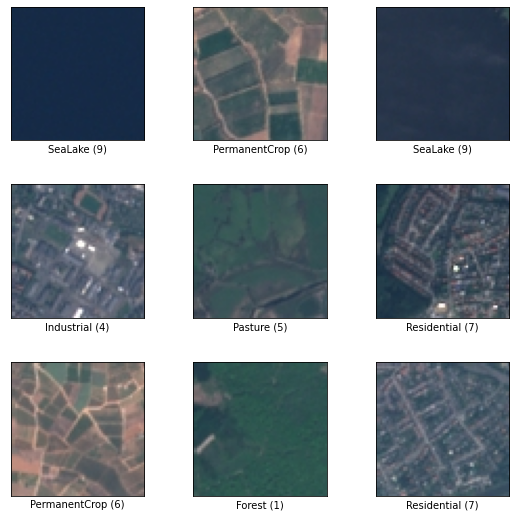

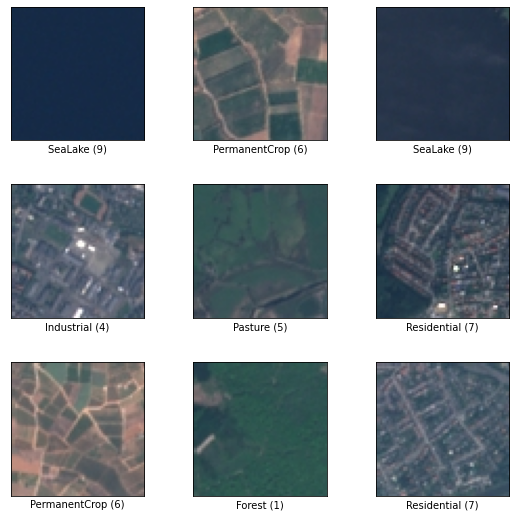

In [5]:
tfds.show_examples(ds, ds_info)

In [6]:
# Take one sample
d = ds.take(1)

for example in d:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    print(list(example.keys()))
    image = example["image"]
    label = example["label"]
    print(image.shape, label)

['filename', 'image', 'label']
(64, 64, 3) tf.Tensor(9, shape=(), dtype=int64)


In [7]:
# Split the full dataset into 80% as train set
train, info = tfds.load('eurosat/rgb',
                        with_info=True,
                        split='train[:80%]',
                        batch_size=-1,
                        data_dir=DATA_DIR)
X_train = tfds.as_numpy(train['image'])
y_train = tfds.as_numpy(train['label'])

# Encode labels
y_train = to_categorical(y_train, num_classes=10)

In [8]:
X_train_Resized = np.zeros((21600,32,32,3))

for i in range(21600) :
    X_train_Resized[i] = np.resize(X_train[i],(32,32,3))

In [9]:
X_train_Resized.shape

(21600, 32, 32, 3)

**I would like to resize my images to 32x32x3.

# Implementation of ShuffleNet

**Model Definition**

In [10]:
def channel_split(x, name=''):
    # equipartition
    in_channles = x.shape.as_list()[-1]
    ip = in_channles // 2
    c_hat = Lambda(lambda z: z[:, :, :, 0:ip], name='%s/sp%d_slice' % (name, 0))(x)
    c = Lambda(lambda z: z[:, :, :, ip:], name='%s/sp%d_slice' % (name, 1))(x)
    return c_hat, c

def channel_shuffle(x):
    height, width, channels = x.shape.as_list()[1:]
    channels_per_split = channels // 2
    x = K.reshape(x, [-1, height, width, 2, channels_per_split])
    x = K.permute_dimensions(x, (0,1,2,4,3))
    x = K.reshape(x, [-1, height, width, channels])
    return x


def shuffle_unit(inputs, out_channels, bottleneck_ratio,strides=2,stage=1,block=1):
    if K.image_data_format() == 'channels_last':
        bn_axis = -1
    else:
        raise ValueError('Only channels last supported')

    prefix = 'stage{}/block{}'.format(stage, block)
    bottleneck_channels = int(out_channels * bottleneck_ratio)
    if strides < 2:
        c_hat, c = channel_split(inputs, '{}/spl'.format(prefix))
        inputs = c

    x = Conv2D(bottleneck_channels, kernel_size=(1,1), strides=1, padding='same', name='{}/1x1conv_1'.format(prefix))(inputs)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_1'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_1'.format(prefix))(x)
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', name='{}/3x3dwconv'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv'.format(prefix))(x)
    x = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1conv_2'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_2'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_2'.format(prefix))(x)

    if strides < 2:
        ret = Concatenate(axis=bn_axis, name='{}/concat_1'.format(prefix))([x, c_hat])
    else:
        s2 = DepthwiseConv2D(kernel_size=3, strides=2, padding='same', name='{}/3x3dwconv_2'.format(prefix))(inputs)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv_2'.format(prefix))(s2)
        s2 = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1_conv_3'.format(prefix))(s2)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_3'.format(prefix))(s2)
        s2 = Activation('relu', name='{}/relu_1x1conv_3'.format(prefix))(s2)
        ret = Concatenate(axis=bn_axis, name='{}/concat_2'.format(prefix))([x, s2])

    ret = Lambda(channel_shuffle, name='{}/channel_shuffle'.format(prefix))(ret)

    return ret


def block(x, channel_map, bottleneck_ratio, repeat=1, stage=1):
    x = shuffle_unit(x, out_channels=channel_map[stage-1],
                      strides=2,bottleneck_ratio=bottleneck_ratio,stage=stage,block=1)

    for i in range(1, repeat+1):
        x = shuffle_unit(x, out_channels=channel_map[stage-1],strides=1,
                          bottleneck_ratio=bottleneck_ratio,stage=stage, block=(1+i))

    return x


def ShuffleNetV2(include_top=True,
                 input_tensor=None,
                 scale_factor=1.0,
                 pooling='max',
                 input_shape=(32,32,3),
                 load_model=None,
                 num_shuffle_units=[3,7,3],
                 bottleneck_ratio=1,
                 classes=131):
    if K.backend() != 'tensorflow':
        raise RuntimeError('Only tensorflow supported for now')
    name = 'ShuffleNetV2_{}_{}_{}'.format(scale_factor, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))
    input_shape = input_shape
  
    out_dim_stage_two = {0.5:48, 1:116, 1.5:176, 2:244}

    if pooling not in ['max', 'avg']:
        raise ValueError('Invalid value for pooling')
    if not (float(scale_factor)*4).is_integer():
        raise ValueError('Invalid value for scale_factor, should be x over 4')
    exp = np.insert(np.arange(len(num_shuffle_units), dtype=np.float32), 0, 0)  # [0., 0., 1., 2.]
    out_channels_in_stage = 2**exp
    out_channels_in_stage *= out_dim_stage_two[bottleneck_ratio]  #  calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage *= scale_factor
    out_channels_in_stage = out_channels_in_stage.astype(int)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # create shufflenet architecture
    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same', use_bias=False, strides=(2, 2),
               activation='relu', name='conv1')(img_input)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='maxpool1')(x)

    # create stages containing shufflenet units beginning at stage 2
    for stage in range(len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = block(x, out_channels_in_stage,
                   repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   stage=stage + 2)

    if bottleneck_ratio < 2:
        k = 1024
    else:
        k = 2048
    x = Conv2D(k, kernel_size=1, padding='same', strides=1, name='1x1conv5_out', activation='relu')(x)

    if pooling == 'avg':
        x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name='global_max_pool')(x)

    if include_top:
        x = Dense(classes, name='fc')(x)
        x = Activation('softmax', name='softmax')(x)

    inputs = img_input
    model = Model(inputs, x, name=name)

    if load_model:
        model.load_weights('', by_name=True)

    return model

**Model Related Definitions**

In [11]:
input_shape = (64,64,3)
CLASS_NUMBER = 10
batch_size = 64
optimizer = "adam"
epochs = 16

**Create Model**

In [12]:
base_model = ShuffleNetV2(include_top=False, input_shape= (input_shape))

inputs = tf.keras.Input(shape=(input_shape))

x = base_model(inputs)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

ShuffleNet_model = Model(inputs = inputs, outputs = predictions)

ShuffleNet_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
ShuffleNetV2_1.0_1_373 (Func (None, 1024)              4018740   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
Total params: 4,033,086
Trainable params: 4,002,918
Non-trainable params: 30,168
_________________________________________________________________


**Compile Model**

In [13]:
ShuffleNet_model.compile(loss='categorical_crossentropy',
             optimizer=optimizer, metrics=['accuracy'])


history_ShuffleNet_model = ShuffleNet_model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size)

Epoch 1/16


2022-08-26 07:33:41.624607: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


270/270 [==============================] - 24s 39ms/step - loss: 1.4059 - accuracy: 0.5271 - val_loss: 2.9003 - val_accuracy: 0.0907
Epoch 2/16
270/270 [==============================] - 10s 37ms/step - loss: 0.8342 - accuracy: 0.7059 - val_loss: 2.9421 - val_accuracy: 0.0921
Epoch 3/16
270/270 [==============================] - 9s 34ms/step - loss: 0.7088 - accuracy: 0.7575 - val_loss: 1.7713 - val_accuracy: 0.4963
Epoch 4/16
270/270 [==============================] - 10s 38ms/step - loss: 0.6421 - accuracy: 0.7818 - val_loss: 0.7637 - val_accuracy: 0.7322
Epoch 5/16
270/270 [==============================] - 9s 34ms/step - loss: 0.5630 - accuracy: 0.8131 - val_loss: 1.6823 - val_accuracy: 0.5620
Epoch 6/16
270/270 [==============================] - 10s 36ms/step - loss: 0.5011 - accuracy: 0.8319 - val_loss: 1.7107 - val_accuracy: 0.5838
Epoch 7/16
270/270 [==============================] - 9s 34ms/step - loss: 0.5541 - accuracy: 0.8149 - val_loss: 1.9114 - val_accuracy: 0.5315
Epoch 

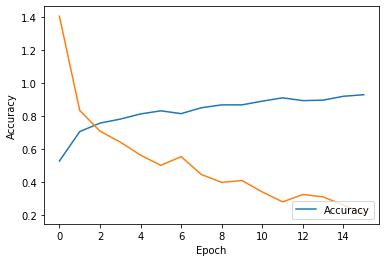

In [14]:
plt.plot(history_ShuffleNet_model.history['accuracy'])
plt.plot(history_ShuffleNet_model.history['loss'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy'], loc='lower right')

In [15]:
ShuffleNet_model.save("shufflenet_eurosat.h5")